## Deep Learning Multiclass Challenge (CAD Project)

Author: **Muhammad Zain Amin**
<br>
Erasmus Mundus Joint Master Degree in Medical Imaging and Applications (MAIA)
<br>
University of Girona, Spain

#### Libraries

In [ ]:
import copy
import time
import sys
import logging
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps
from typing import Optional, Sequence

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from skimage import io

#### Import Functions and Classes

In [20]:
from imshow import imshow
from visualize_model import visualize_model
from focal_loss import FocalLoss
from train_model import train_model
from test_model import test_model
from plot_confusion_matrix import plot_confusion_matrix
from plot_roc import plot_roc
from Imbalanced_Dataset_Sampler import ImbalancedDatasetSampler 
from Challenge_2_Dataset import Challenge2Dataset
from Data_Samples import get_samples_count
from models import ModelFactory

#### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset Directories

In [ ]:
# Image directories
train_img_folder = '/content/drive/MyDrive/CAD/Dataset/train/train'
val_img_folder = '/content/drive/MyDrive/CAD/Dataset/val/val'
test_img_folder = '/content/drive/MyDrive/CAD/Dataset/test'

# CSV paths
train_csv_path = '/content/drive/MyDrive/CAD/Dataset/train_labels.csv'
val_csv_path = '/content/drive/MyDrive/CAD/Dataset/val_labels.csv'
test_csv_path = '/content/drive/MyDrive/CAD/Dataset/test_ids.csv'

#### Parameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
NEW_SIZE = 256
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 2
MU = [0.6138, 0.5056, 0.4985]
STD = [0.1611, 0.1672, 0.1764]

#### Data Transformations

In [ ]:
img_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean= MU, std=STD)
                                  ])

In [ ]:
dataset_train = Challenge2Dataset(csv_file=train_csv_path,
                             image_folder= train_img_folder,
                             img_transform = img_transforms,
                             augment = True)

In [ ]:
dataset_val = Challenge2Dataset(csv_file=val_csv_path,
                            image_folder= val_img_folder,
                            img_transform = img_transforms,
                            augment=False)


#### Data Loaders

In [ ]:
y = dataset_train.get_labels()
class_weights= class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y), y= np.array(y))
class_weights =  torch.tensor(class_weights).float().to(DEVICE)

In [ ]:
# Balanced training dataloader
mean_samples = get_samples_count(dataset_train.get_labels(), 'mean')
data_sampler = ImbalancedDatasetSampler(dataset_train, indices=None, num_samples=mean_samples, replacement = True)
train_loader_balanced = DataLoader(dataset_train, sampler=data_sampler, num_workers=NUM_WORKERS,
                             batch_size=TRAIN_BATCH_SIZE)

In [ ]:
val_loader_shuff = DataLoader(dataset_val, batch_size=8, num_workers=NUM_WORKERS, shuffle=True)

In [ ]:
# dataloaders with the original number of samples in the dataset
train_loader = DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)


In [ ]:
dataloaders = {"train": train_loader,"val": val_loader}
dataloaders_balanced = {"train": train_loader_balanced,"val": val_loader}

# Training and Results

#### Swin S Model

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/CAD/Swin/swin_s_ce_all.txt", level=logging.INFO,format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/CAD/Swin'

In [ ]:
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-8
model_factory = ModelFactory()
swin = model_factory.make_swin_s(True, DEVICE)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(swin.parameters(), lr = LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

Downloading: "https://download.pytorch.org/models/swin_s-5e29d889.pth" to /root/.cache/torch/hub/checkpoints/swin_s-5e29d889.pth
100%|██████████| 190M/190M [00:11<00:00, 17.6MB/s]


In [ ]:
logging.info('Model:swin_s, LR: 1e-4, LR patience = 7, loss: CE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, without sampling')

Model:swin_s, LR: 1e-4, LR patience = 7, loss: CE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, without sampling


In [ ]:
#number of samples in each set
dataset_sizes = {'train': len(dataset_train),'val':len(dataset_val),}

In [ ]:
checkpoint_p = '/content/drive/MyDrive/CAD/swin_s_ce.pth'
swin = train_model(swin, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [30:24<00:00,  5.74s/it]

train epoch 1 : loss : 0.5510, acc: 0.7893, kappa: 0.6044



100%|██████████| 20/20 [07:46<00:00, 23.35s/it]

val epoch 1 : loss : 0.3704, acc: 0.8535, kappa: 0.7313



Epoch 2/100
---------------


100%|██████████| 318/318 [02:10<00:00,  2.44it/s]

train epoch 2 : loss : 0.4039, acc: 0.8499, kappa: 0.7211



100%|██████████| 20/20 [00:28<00:00,  1.40s/it]

val epoch 2 : loss : 0.3419, acc: 0.8732, kappa: 0.7621



Epoch 3/100
---------------


100%|██████████| 318/318 [02:09<00:00,  2.46it/s]

train epoch 3 : loss : 0.3799, acc: 0.8597, kappa: 0.7407



100%|██████████| 20/20 [00:27<00:00,  1.40s/it]

val epoch 3 : loss : 0.2919, acc: 0.8992, kappa: 0.8153



Epoch 4/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train epoch 4 : loss : 0.3361, acc: 0.8715, kappa: 0.7645



100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

val epoch 4 : loss : 0.2919, acc: 0.8898, kappa: 0.7981



Epoch 5/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train epoch 5 : loss : 0.3060, acc: 0.8849, kappa: 0.7887



100%|██████████| 20/20 [00:25<00:00,  1.25s/it]

val epoch 5 : loss : 0.2666, acc: 0.9087, kappa: 0.8305



Epoch 6/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train epoch 6 : loss : 0.2593, acc: 0.9059, kappa: 0.8286



100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

val epoch 6 : loss : 0.2269, acc: 0.9276, kappa: 0.8683



Epoch 7/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train epoch 7 : loss : 0.2415, acc: 0.9140, kappa: 0.8437



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 7 : loss : 0.2238, acc: 0.9220, kappa: 0.8601



Epoch 8/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train epoch 8 : loss : 0.2259, acc: 0.9170, kappa: 0.8493



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 8 : loss : 0.2495, acc: 0.9197, kappa: 0.8565



Epoch 9/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train epoch 9 : loss : 0.2194, acc: 0.9179, kappa: 0.8511



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 9 : loss : 0.2177, acc: 0.9205, kappa: 0.8582



Epoch 10/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train epoch 10 : loss : 0.1949, acc: 0.9323, kappa: 0.8772



100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

val epoch 10 : loss : 0.2337, acc: 0.9220, kappa: 0.8582



Epoch 11/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]


train epoch 11 : loss : 0.1861, acc: 0.9278, kappa: 0.8694


100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

val epoch 11 : loss : 0.2636, acc: 0.9102, kappa: 0.8386



Epoch 12/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train epoch 12 : loss : 0.1703, acc: 0.9353, kappa: 0.8828



100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

val epoch 12 : loss : 0.2026, acc: 0.9354, kappa: 0.8839



Epoch 13/100
---------------


100%|██████████| 318/318 [02:09<00:00,  2.46it/s]

train epoch 13 : loss : 0.1526, acc: 0.9449, kappa: 0.9004



100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

val epoch 13 : loss : 0.2118, acc: 0.9260, kappa: 0.8658



Epoch 14/100
---------------


100%|██████████| 318/318 [02:09<00:00,  2.46it/s]

train epoch 14 : loss : 0.1512, acc: 0.9471, kappa: 0.9044



100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

val epoch 14 : loss : 0.1693, acc: 0.9417, kappa: 0.8953



Epoch 15/100
---------------


100%|██████████| 318/318 [02:09<00:00,  2.46it/s]

train epoch 15 : loss : 0.1461, acc: 0.9479, kappa: 0.9059



100%|██████████| 20/20 [00:27<00:00,  1.40s/it]

val epoch 15 : loss : 0.1865, acc: 0.9362, kappa: 0.8862



Epoch 16/100
---------------


100%|██████████| 318/318 [02:11<00:00,  2.41it/s]

train epoch 16 : loss : 0.1422, acc: 0.9488, kappa: 0.9074



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 16 : loss : 0.2100, acc: 0.9283, kappa: 0.8730



Epoch 17/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train epoch 17 : loss : 0.1309, acc: 0.9486, kappa: 0.9074



100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

val epoch 17 : loss : 0.1862, acc: 0.9402, kappa: 0.8920



Epoch 18/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train epoch 18 : loss : 0.1295, acc: 0.9526, kappa: 0.9145



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 18 : loss : 0.1675, acc: 0.9449, kappa: 0.9012



Epoch 19/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.49it/s]

train epoch 19 : loss : 0.1241, acc: 0.9538, kappa: 0.9165



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 19 : loss : 0.1862, acc: 0.9378, kappa: 0.8882



Epoch 20/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train epoch 20 : loss : 0.1110, acc: 0.9610, kappa: 0.9298



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 20 : loss : 0.1822, acc: 0.9409, kappa: 0.8955



Epoch 21/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train epoch 21 : loss : 0.1131, acc: 0.9614, kappa: 0.9305



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 21 : loss : 0.2079, acc: 0.9307, kappa: 0.8752



Epoch 22/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.49it/s]

train epoch 22 : loss : 0.1020, acc: 0.9665, kappa: 0.9397



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 22 : loss : 0.1960, acc: 0.9457, kappa: 0.9023



Epoch 23/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.50it/s]

train epoch 23 : loss : 0.1063, acc: 0.9622, kappa: 0.9320



100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

val epoch 23 : loss : 0.2263, acc: 0.9299, kappa: 0.8724



Epoch 24/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.53it/s]

train epoch 24 : loss : 0.0896, acc: 0.9685, kappa: 0.9432



100%|██████████| 20/20 [00:25<00:00,  1.30s/it]

val epoch 24 : loss : 0.2072, acc: 0.9362, kappa: 0.8858



Epoch 25/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.52it/s]

train epoch 25 : loss : 0.1133, acc: 0.9614, kappa: 0.9304



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 25 : loss : 0.1754, acc: 0.9441, kappa: 0.9007



Epoch 26/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train epoch 26 : loss : 0.0945, acc: 0.9673, kappa: 0.9411



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 26 : loss : 0.1477, acc: 0.9535, kappa: 0.9170



Epoch 27/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train epoch 27 : loss : 0.0738, acc: 0.9750, kappa: 0.9550



100%|██████████| 20/20 [00:26<00:00,  1.35s/it]

val epoch 27 : loss : 0.1901, acc: 0.9433, kappa: 0.8992



Epoch 28/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train epoch 28 : loss : 0.0914, acc: 0.9683, kappa: 0.9429



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 28 : loss : 0.2251, acc: 0.9315, kappa: 0.8752



Epoch 29/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train epoch 29 : loss : 0.0836, acc: 0.9707, kappa: 0.9472



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 29 : loss : 0.1783, acc: 0.9528, kappa: 0.9143



Epoch 30/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train epoch 30 : loss : 0.0877, acc: 0.9689, kappa: 0.9439



100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

val epoch 30 : loss : 0.2318, acc: 0.9362, kappa: 0.8830



Epoch 31/100
---------------


100%|██████████| 318/318 [02:09<00:00,  2.46it/s]

train epoch 31 : loss : 0.0927, acc: 0.9671, kappa: 0.9408



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 31 : loss : 0.1886, acc: 0.9409, kappa: 0.8942



Epoch 32/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.49it/s]

train epoch 32 : loss : 0.0817, acc: 0.9721, kappa: 0.9497



100%|██████████| 20/20 [00:24<00:00,  1.25s/it]

val epoch 32 : loss : 0.2154, acc: 0.9433, kappa: 0.8979



Epoch 33/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train epoch 33 : loss : 0.0801, acc: 0.9705, kappa: 0.9468



100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

val epoch 33 : loss : 0.2121, acc: 0.9378, kappa: 0.8891



Epoch 34/100
---------------


100%|██████████| 318/318 [02:06<00:00,  2.51it/s]

train epoch 34 : loss : 0.0741, acc: 0.9728, kappa: 0.9511



100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

val epoch 34 : loss : 0.2012, acc: 0.9370, kappa: 0.8871



Epoch 35/100
---------------


100%|██████████| 318/318 [02:07<00:00,  2.49it/s]

train epoch 35 : loss : 0.0502, acc: 0.9835, kappa: 0.9702



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 35 : loss : 0.1627, acc: 0.9559, kappa: 0.9211



Epoch 36/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.47it/s]

train epoch 36 : loss : 0.0275, acc: 0.9915, kappa: 0.9848



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 36 : loss : 0.1637, acc: 0.9551, kappa: 0.9198



Epoch 37/100
---------------


100%|██████████| 318/318 [02:08<00:00,  2.48it/s]

train epoch 37 : loss : 0.0233, acc: 0.9931, kappa: 0.9876



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 37 : loss : 0.1618, acc: 0.9583, kappa: 0.9254



Epoch 38/100
---------------


100%|██████████| 318/318 [02:10<00:00,  2.45it/s]

train epoch 38 : loss : 0.0236, acc: 0.9925, kappa: 0.9865



100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

val epoch 38 : loss : 0.1672, acc: 0.9598, kappa: 0.9280



Epoch 39/100
---------------


100%|██████████| 318/318 [02:10<00:00,  2.44it/s]

train epoch 39 : loss : 0.0273, acc: 0.9917, kappa: 0.9851



100%|██████████| 20/20 [00:26<00:00,  1.30s/it]

val epoch 39 : loss : 0.1719, acc: 0.9575, kappa: 0.9241


EARLY STOP AFTER 39 EPOCHS
Training complete in 138m 52s
Best val loss: 0.147705
Best val Kappa: 0.9280310943007115


#### Load the saved model

In [ ]:
swin_s_best_1 = model_factory.make_swin_s(False, DEVICE)
swin_s_best_1.load_state_dict(torch.load('/content/drive/MyDrive/CAD/swin_s_ce_best.pth'))

<All keys matched successfully>

In [ ]:
since = time.time()
swin_s_best_1.eval()
running_labels = []
running_preds = []
outputs_all = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs = swin_s_best_1(inputs)
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
        probas = F.softmax(outputs, dim=1)
        outputs_all.append(probas.cpu().numpy())
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')
    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

Test Acc: 0.9598, kappa: 0.9280
Testing complete in 0m 26s


Confusion matrix, without normalization
[[651  19   8]
 [  8 484   6]
 [  8   2  84]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

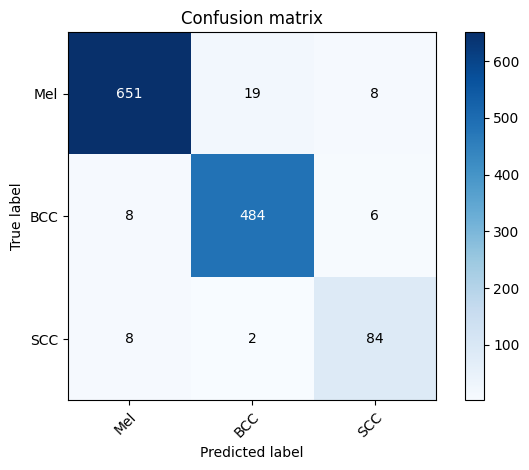

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

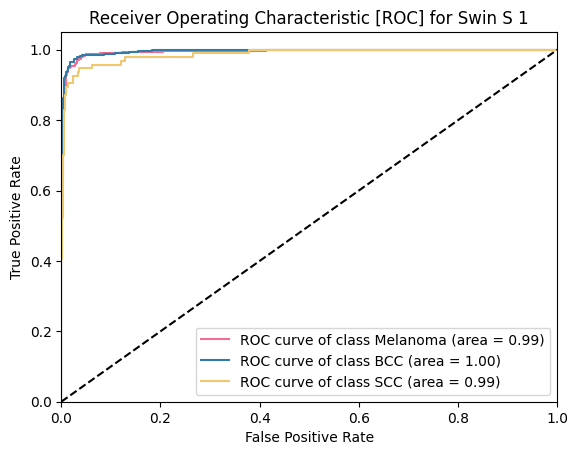

{0: 0.994513872279359, 1: 0.995372682439603, 2: 0.9863402807931684}

In [ ]:
probas = np.vstack(outputs_all)
plot_roc(running_labels, probas, True, 'Swin S 1')

In [ ]:
test_df = pd.read_csv(test_csv_path)
test_ids = []
test_preds = []
for i, row in test_df.iterrows():
  img_id = '/' + row['Image_ID'] 

  img_path = test_img_folder + img_id + '.jpg' 
  image = Image.open(img_path)  
  image = img_transforms(image).unsqueeze(0).to(DEVICE)

  outputs_1 = swin_s_best_1(image)
  outputs = outputs_1
  _, preds = torch.max(outputs, 1)
  test_preds = test_preds + preds.int().cpu().tolist()
  test_ids.append(img_id)
  print(f"Image {row['Image_ID']} done")

Image xxx01102 done
Image xxx01122 done
Image xxx01137 done
Image xxx01096 done
Image xxx01126 done
Image xxx01121 done
Image xxx01089 done
Image xxx01095 done
Image xxx01087 done
Image xxx01109 done
Image xxx01110 done
Image xxx01107 done
Image xxx01091 done
Image xxx01125 done
Image xxx01082 done
Image xxx01101 done
Image xxx01156 done
Image xxx01195 done
Image xxx01158 done
Image xxx01180 done
Image xxx01181 done
Image xxx01189 done
Image xxx01188 done
Image xxx01148 done
Image xxx01162 done
Image xxx01182 done
Image xxx01147 done
Image xxx01179 done
Image xxx01138 done
Image xxx01170 done
Image xxx01171 done
Image xxx01174 done
Image xxx01160 done
Image xxx01164 done
Image xxx01161 done
Image xxx01173 done
Image xxx01153 done
Image xxx01178 done
Image xxx01145 done
Image xxx01152 done
Image xxx01142 done
Image xxx01191 done
Image xxx01143 done
Image xxx01193 done
Image xxx01155 done
Image xxx01194 done
Image xxx01200 done
Image xxx01184 done
Image xxx01196 done
Image xxx01144 done


#### Load the saved model

In [ ]:
test_dict = {'img_id': test_ids, 'prediction': test_preds}
test_inf_df = pd.DataFrame(test_dict)
test_inf_df.to_csv('/content/drive/MyDrive/CAD/test_results_swin_s_1.csv')